## mag_auto_calc

Testing MAG_AUTO calculations using [SEP](https://github.com/kbarbary/sep), which has the functionality of SExtractor wrapped in Python.

In [1]:
# math, array manipulation, etc.
import numpy as np

# timing
from timeit import default_timer
from tqdm import tqdm

import astropy.io.fits as fits
from astropy.table import Table                    # Table data structure
import astropy.units as u

# necessary utilities from scipy, astropy and photutils
from scipy.optimize import differential_evolution
from scipy.ndimage import maximum_filter, gaussian_filter
from astropy.modeling import functional_models
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from photutils.background import Background2D, StdBackgroundRMS
from photutils.segmentation import deblend_sources, SegmentationImage, detect_sources

# plots
import matplotlib.pyplot as plt
import corner                       # giant triangle confusograms!

#%matplotlib inline

# MCMC sampling package
import emcee

# SEP
import sep

import os

import sys
print(sys.version)


/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]


In [2]:
sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from lensphoto import LensPhoto, fwhm2sigma

from aidan_utils import plot_prettier, read_fits_image, get_fits_files

# only need to run once
plot_prettier()

In [18]:
jr_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/'
jg_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/'

files_r = get_fits_files(jr_path)
files_g = get_fits_files(jg_path)

index = 19

img_r = fits.open(files_r[index])[0].data
img_g = fits.open(files_g[index])[0].data

print(files_r[index])
print(files_g[index])


/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/DESJ011357.1056-292439.2400_r.fits
/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/DESJ011357.1056-292439.2400_g.fits


In [4]:
# begin by calling a quick fit

# then test bootstrapping using the example in the pyimfit documentation

# then run an MCMC call and compare posterior distributions using corner
# (change to imfit's likelihood calculation, see ## comments in infit_mcmc function)

fwhm_r = 0.95
fwhm_g = 1.11

std_psf_r = fwhm2sigma(fwhm_r)
std_psf_g = fwhm2sigma(fwhm_g)


In [5]:
photo = LensPhoto(img_r = img_r, img_g = img_g
                  , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                  , desid = '1'
                  , nwalkers=20, steps=400)


[[2.3744495 2.3744495 2.3744495 ... 2.3744495 2.3744495 2.3744495]
 [2.971353  2.4691079 2.3744495 ... 2.3744495 2.3744495 2.3744495]
 [3.0099201 2.7045536 2.3744495 ... 2.3744495 2.3744495 2.3744495]
 ...
 [2.3744495 2.3744495 2.3744495 ... 2.3744495 2.3744495 2.3744495]
 [2.3744495 2.3744495 2.3744495 ... 3.0202494 2.3744495 2.5978959]
 [2.3744495 2.6497347 2.7573473 ... 2.4060159 2.3797812 3.0394132]]
[[1.9237863 2.047411  1.8631384 ... 1.8631384 2.3572457 1.8631384]
 [1.8631384 2.6952124 2.2543697 ... 1.8631384 1.9017367 1.8631384]
 [2.2167306 1.8631384 2.1703064 ... 1.8631384 1.9118364 1.8631384]
 ...
 [1.8631384 2.165762  1.8631384 ... 1.8631384 1.8631384 1.8731713]
 [1.8631384 1.8631384 1.8631384 ... 1.8631384 1.9416807 1.8631384]
 [1.9785538 1.8631384 1.8631384 ... 1.8631384 2.2249026 1.8631384]]


/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:214: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:214: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
run, dist = photo.mcmc_run()
# this is a good number of steps and walkers for the production run MCMCs

samples = photo.dist.reshape(-1, 8)


  0%|                                                   | 0/400 [00:00<?, ?it/s]/Users/aidan/opt/anaconda3/envs/gal-gal-sel/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 400/400 [02:05<00:00,  3.18it/s]


----------------------------



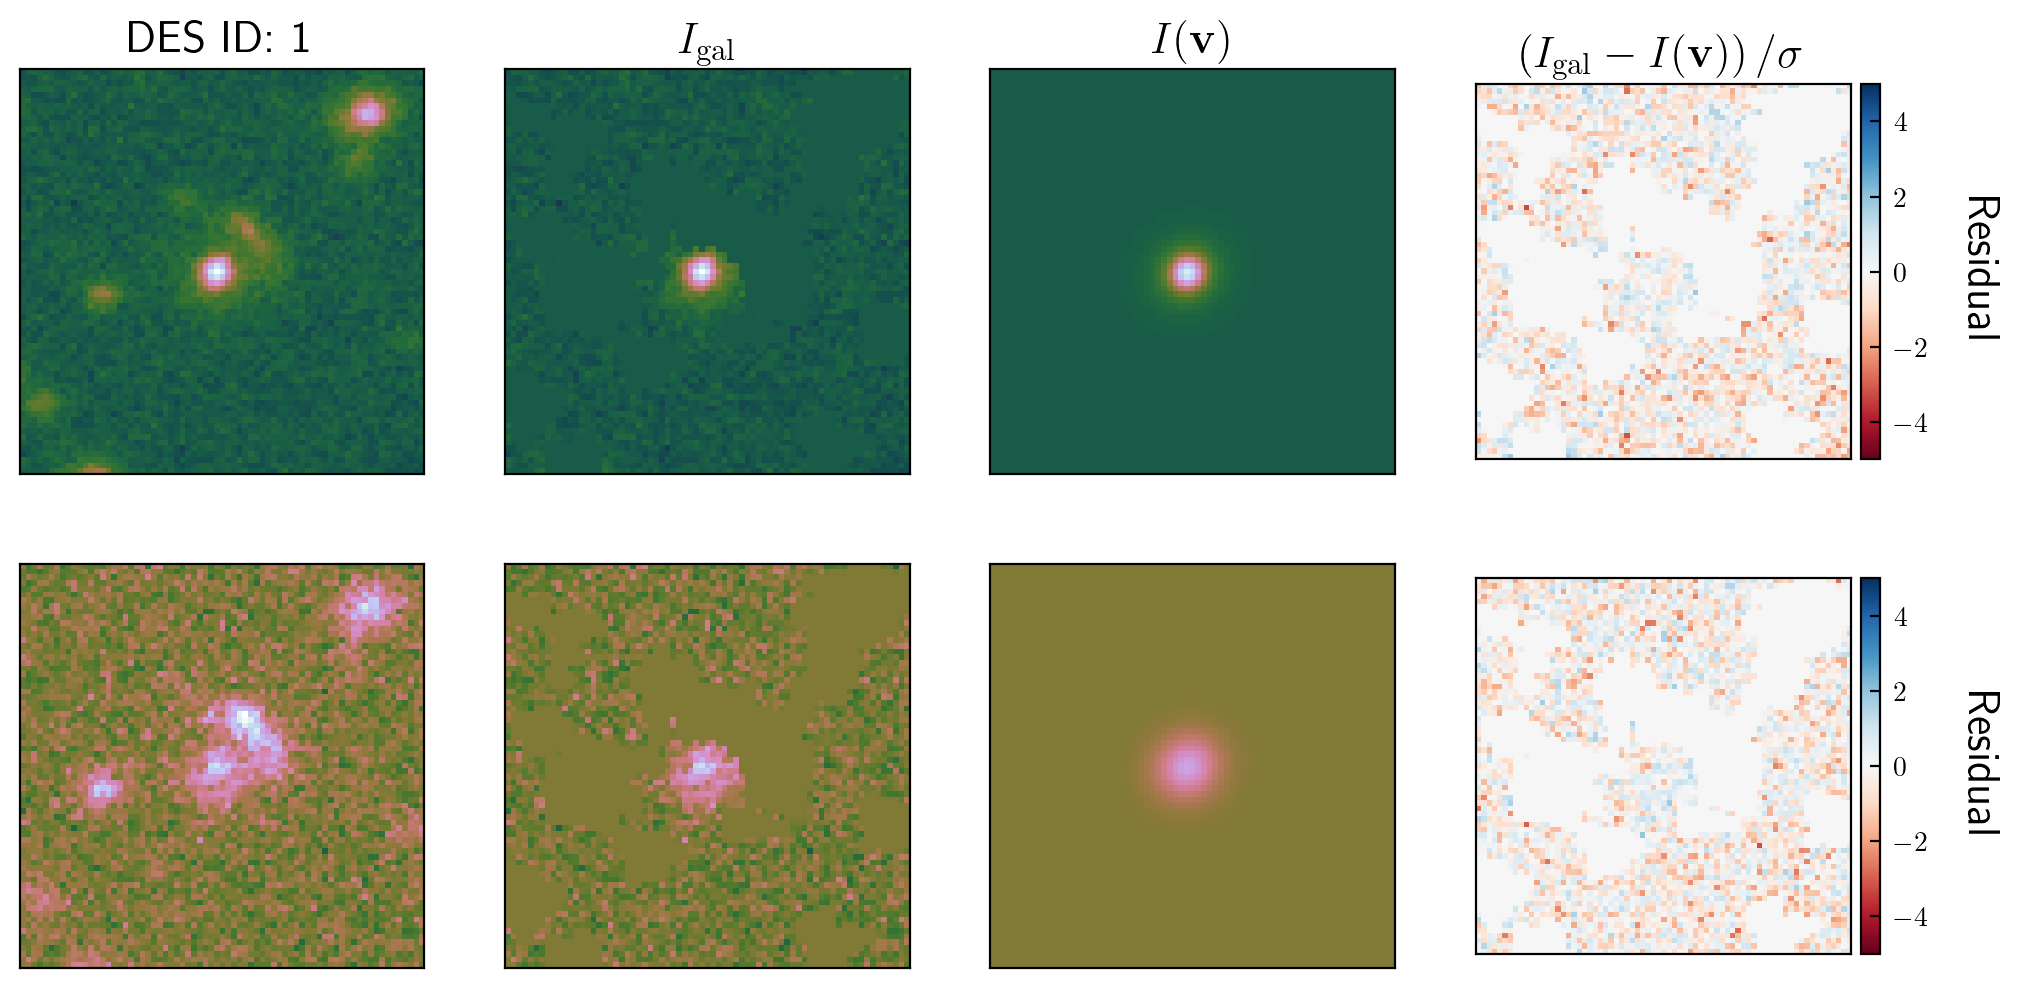

In [7]:
profile_r, profile_g = photo.plot_gal()


In [8]:
rmag_arr, gmag_arr = photo.mag_arrays()

0it [00:00, ?it/s]/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/lensphoto.py:697: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5*np.log10(flux) + 30
2000it [00:39, 50.38it/s]


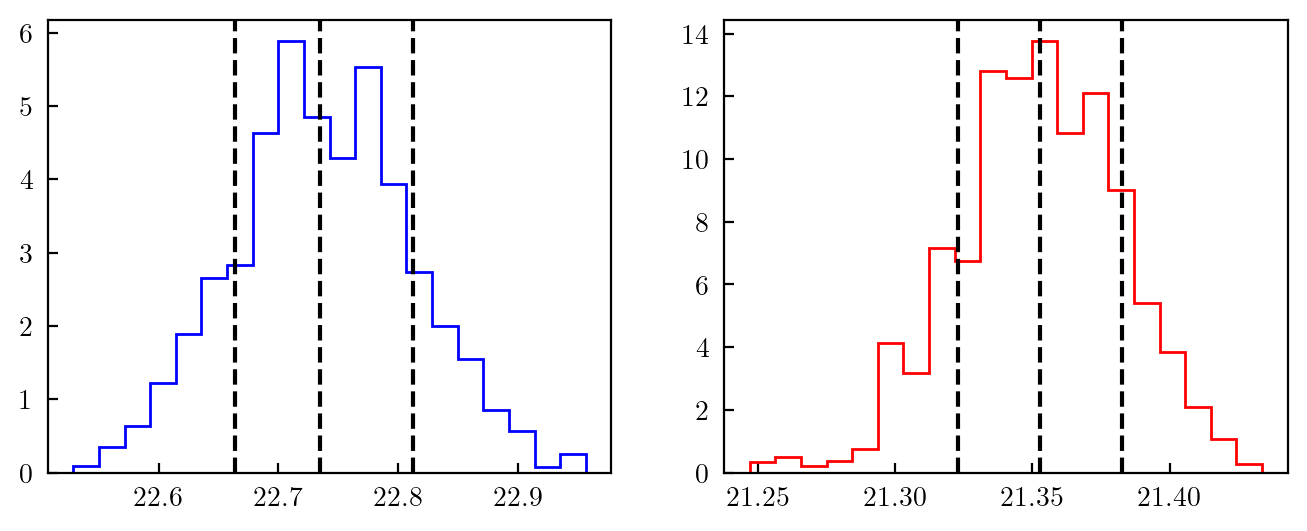

In [17]:
gmag_arr_cut = gmag_arr[gmag_arr < 23]

fig, ax = plt.subplots(1,2, figsize=(8,3))

ax[0].hist(gmag_arr_cut, bins=20, color='blue', histtype='step', density=True)
ax[0].axvline(np.percentile(gmag_arr_cut, 16), linestyle='--', c='black')
ax[0].axvline(np.percentile(gmag_arr_cut, 50), linestyle='--', c='black')
ax[0].axvline(np.percentile(gmag_arr_cut, 84), linestyle='--', c='black')

ax[1].hist(rmag_arr, bins=20, color='red', histtype='step', density=True)
ax[1].axvline(np.percentile(rmag_arr, 16), linestyle='--', c='black')
ax[1].axvline(np.percentile(rmag_arr, 50), linestyle='--', c='black')
ax[1].axvline(np.percentile(rmag_arr, 84), linestyle='--', c='black')

plt.show()

#### Below, I'm testing functionality of individual steps

Full function with SEP functionalities, to be added to `LensPhoto` class.

In [94]:
samples.shape

(6000, 8)

In [136]:
def norm_to_notnorm(v, photo=photo):
    '''
    takes a sample from the posterior and calculates non-normalized amplitude
    '''
        
    x0, y0, th, e, nr, rr, ng, rg = v
        
    gal_filt_r = photo.img_gal_r[photo.unmask]
    gal_filt_g = photo.img_gal_g[photo.unmask]
        
    stds_filt_r = photo.stds_r[photo.unmask]
    stds_filt_g = photo.stds_g[photo.unmask]
        
    # r-band
    norm_params_r = np.array([x0, y0, th, e, nr, 1.0, rr])
    norm_profile_r = photo.imfit_r.getModelImage(newParameters=norm_params_r)
    norm_filt_r = norm_profile_r[photo.unmask]
        
    # g-band
    norm_params_g = np.array([x0, y0, th, e, ng, 1.0, rg])
    norm_profile_g = photo.imfit_g.getModelImage(newParameters=norm_params_g)
    norm_filt_g = norm_profile_g[photo.unmask]
    
    # find amplitudes, then replace in parameter arrays
    # r-band
    Ie_r = np.sum((norm_filt_r * (gal_filt_r))
                  / (stds_filt_r)**2) / np.sum((norm_filt_r)**2 
                                               / (stds_filt_r)**2)
        
    # g-band
    Ie_g = np.sum((norm_filt_g * (gal_filt_g))
                  / (stds_filt_g)**2) / np.sum((norm_filt_g)**2 
                                               / (stds_filt_g)**2)
        
    return Ie_r, Ie_g

def calc_mag_auto(model):
    '''
    takes a model galaxy image and calculates the galaxy's MAG_AUTO value
    '''
        
    objs = sep.extract(model, 3, err=0.)
    x, y, a, b, theta = objs['x'], objs['y'], objs['a'], objs['b'], objs['theta']
        
    kronrad, krflag = sep.kron_radius(model, x, y, a, b, theta, 6.0)
    rscale = 15 * kronrad

    flux, fluxerr, flag = sep.sum_ellipse(model, x, y, a, b, theta, rscale,
                                              subpix=1)
    mag = -2.5*np.log10(flux) + 30
    
    valid_inds = (np.isfinite(mag) #| np.isnan(mag)
                   )
    
    # if there is more than one mag value and only one is a number, then take mag to be that number
    # if there is more than one mag value and none are numbers, then take mag to be first index
    # if there is more than one mag value and multiple are numbers, then take mag to be the largest number
    
    if (len(mag) > 1) and (len(mag[valid_inds]) == 1):
        mag = mag[valid_inds]
        
    elif (len(mag) > 1) and (len(mag[valid_inds]) > 1):
        mag = mag[valid_inds]
        max_ind = np.argmax(mag)
        
        mag = mag[max_ind]
        
    elif (len(mag) > 1) and (len(mag[valid_inds]) < 1):
        mag = mag[0]
    
    return mag

photo.burnin = 200

def mag_arrays(photo=photo):
    '''
    calculates MAG_AUTO value for each step in the sampled posterior distribution
    '''
        
    photo.rmag_arr = np.full(photo.nwalkers * (photo.steps - photo.burnin), 1.)
    photo.gmag_arr = np.full(photo.nwalkers * (photo.steps - photo.burnin), 1.)
    
    print(photo.rmag_arr.shape)
        
    try:
        samples = photo.dist.reshape(-1, 8)
        
        for ind, sample in tqdm(enumerate(samples)):
            
            x0, y0, th, e, nr, rr, ng, rg = sample
            
            Ie_r, Ie_g = norm_to_notnorm(sample)
            
            # r-band
            
            params_r = np.array([x0, y0, th, e, nr, Ie_r, rr])
            profile_r = photo.imfit_r.getModelImage(newParameters=params_r)
            
            mag_r = calc_mag_auto(profile_r)
            photo.rmag_arr[ind] = mag_r
            
            # g-band
            
            params_g = np.array([x0, y0, th, e, ng, Ie_g, rg])
            profile_g = photo.imfit_r.getModelImage(newParameters=params_g)
            
            mag_g = calc_mag_auto(profile_g)
            photo.gmag_arr[ind] = mag_g
            
    except:
        raise NoSamplingError('Posterior distribution must be sampled first.')
    
    return photo.rmag_arr, photo.gmag_arr

In [172]:
gmag_arr_cut = gmag_arr[gmag_arr < 23]

SEP functionalities

In [110]:
objs = sep.extract(photo.profile_r, 3, err=0.)

x, y, a, b, theta = objs['x'], objs['y'], objs['a'], objs['b'], objs['theta']
a,b

(array([4.14628935]), array([3.5341804]))

In [106]:
kronrad, krflag = sep.kron_radius(photo.profile_r, x, y, a, b, theta, 6.0)

rscale = 15 * kronrad

flux, fluxerr, flag = sep.sum_ellipse(photo.profile_r, x, y, a, b, theta, rscale,
                                      subpix=1)

mag = -2.5*np.log10(flux) + 30
print(mag)

[21.09217828]
